# Multi-Factor Models

The first part of this notebook summarizes a simple economic model that leads to a multi-factor representation of the expected returns. The second part tests a multi-factor model by OLS.

## Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Statistics, LinearAlgebra

include("src/printmat.jl")
include("src/OlsGMFn.jl");             #funtcion for doing OLS

In [2]:
using Plots, LaTeXStrings
default(size = (480,320),fmt = :png)

# Portfolio Choice with Background Risk

The investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p} = (1-\phi) R_{Fin} + \phi R_{c}$ with $R_{Fin} = w^{\prime}R^e+R_{f}$.

In this definition of the portfolio return, $\phi$ is the fraction of total wealth that is bound to non-traded "assets": this is the background risk.

Combining the two equations and taking expectations gives $\text{E}R_{p} = v'\mu^e + \phi \mu_c^e + R_f$, where $v = w(1-\phi)$ and where $\mu^e$ is the vector of expected excess returns on the risky assets and $\mu_c^e$ is the expected excess return on the background risk. Also, $\text{Var}(R_{p}) = v'\Sigma v + \phi^2 \sigma_{cc} + 2\phi v'S_c,$ where 
$S_{c}$ is a vector of covariances of the risky assets with the background risk,
and $\sigma_{cc}$ is the variance of the background risk.

The optimal portfolio choice (weight on the risky assets within the financial portfolio) is

$
w=\Sigma^{-1} (\mu^e/k-\phi S_c)/(1-\phi).
$

The next cell defines functions for expected utility and the optimal portfolio choice.

### A Remark on the Code

The code uses the subscript $h$ (as in $S_h$ etc) instead of $c$. The reason is that the Julia unicode symbols do not include a subscripted `c`.

In [3]:
"""
    EU

Expected utility for the case with background risk.

The notation follows the text above, except that the subscript h (as in Sₕ) for the non-traded asset, since c is not defined as a subscript in Julia.
"""
function EU(w,ϕ,k,μᵉ,Σ,Sₕ,σₕₕ,μᵉₕ,Rf)
    ER_fin = w'μᵉ + Rf
    ERp    = (1-ϕ)*ER_fin + ϕ*(μᵉₕ+Rf)
    v      = (1-ϕ)*w
    VarRp  = v'*Σ*v + ϕ^2*σₕₕ + 2*ϕ*v'*Sₕ
    EUtil  = ERp - k/2*VarRp
    return EUtil
end

"""
    PortFOpt

Solve for the optimal weight on risky asset (w) in the financial  portfolio.

The notation follows the text above.
"""
function PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)
    wopt  = inv(Σ)*(μᵉ/k-ϕ*Sₕ)/(1-ϕ)
    return wopt
end

PortFOpt

## One Risky Asset

We first consider the case when there is only one risky asset ($w$ is a scalar). We will illustrate several cases ($A,B,C$) which differ with respect to the fraction of non-traded asset (denoted $\phi$) and its covariance with the risk assets (denoted $S_c$ as in the lecture notes or $S_h$ as in the code).

In [4]:
Σ    = 0.08^2    #variance-covariance (matrix) of risky assets, here only one
Sₕ_A = 0         #covariance(s) of risky with background, case A (and B)
Sₕ_C = 0.0025    #case C
(μᵉ,k,σₕₕ,μᵉₕ,Rf) = (0.065,25,0.01,0.02,0.03)

L       = 51
w_range = range(-0.5,1,length=L)  #weight on risky asset in financial portf

(EU_case_A,EU_case_B,EU_case_C) = (fill(NaN,L),fill(NaN,L),fill(NaN,L))
for i in 1:L                    #expected utility at different v values
    EU_case_A[i] = EU(w_range[i],0,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)     #ϕ=0
    EU_case_B[i] = EU(w_range[i],0.5,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ=0
    EU_case_C[i] = EU(w_range[i],0.5,k,μᵉ,Σ,Sₕ_C,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ>0
end

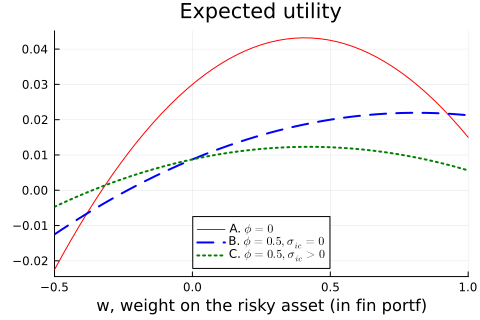

In [5]:
p1 = plot( w_range,[EU_case_A EU_case_B EU_case_C],
           linecolor = [:red :blue :green],
           linestyle = [:solid :dash :dot],
           linewidth = [1 2 2],
           label = [L"A. $\phi=0$" L"B. $\phi=0.5, \sigma_{ic}=0 $" L"C. $\phi=0.5, \sigma_{ic}>0$"],
           xlims = (-0.5,1),
           legend = :bottom,
           title = "Expected utility",
           xlabel = "w, weight on the risky asset (in fin portf)" )
display(p1)

In [6]:
w_A = PortFOpt(0,k,μᵉ,Σ,Sₕ_A)               #optimal portfolio choice
w_B = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_A)
w_C = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_C)

printblue("\nOptimal weight on (a single) risky asset in three cases (ϕ >= 0):\n")
xx = [w_A;w_B;w_C]
colNames = ["in financial portf"]
rowNames = ["A. ϕ=0","B. ϕ=0.5, Sₕ=0","C. ϕ=0.5, Sₕ>0"]
printmat(xx;colNames,rowNames,width=20)

printred("\nCompare with the plot")


Optimal weight on (a single) risky asset in three cases (ϕ >= 0):

                in financial portf
A. ϕ=0                       0.406
B. ϕ=0.5, Sₕ=0               0.812
C. ϕ=0.5, Sₕ>0               0.422


Compare with the plot


## Several Risky Assets

We now consider several risky assets. Notice that $S_c$ (or $S_h$) is now a vector of covariances of each of the investable risky assets with the non-traded asset.

### A Remark on the Code
- The $S_h\; (S_c)$ vector is here created in such a way that we prespecify the correlations (and then scale with the product of the standard deviations of the non-traded assets and the risky assets).

In [7]:
"""
    TheoryParams()

Parameters for the
"""
function TheoryParams()
    μ = [11.5, 9.5, 6]/100          #expected returns
    Σ = [166  34  58;               #covariance matrix
          34  64   4;
          58   4 100]/100^2
    Rf = 0.03

    ϕ   = 0.3                            #fraction of non-traded asset
    σₕₕ = 0.25^2
    Sₕ  = [0.5,0.9,-0.1].*sqrt(σₕₕ).*sqrt.(diag(Σ))  #a vector of covariances
    μₕ  = 0.1
    k   = 8
    return μ,Σ,Rf,ϕ,σₕₕ,Sₕ,μₕ,k
end

TheoryParams

In [8]:
(μ,Σ,Rf,ϕ,σₕₕ,Sₕ,μₕ,k) = TheoryParams()           #parameters

w = PortFOpt(ϕ,k,μ.-Rf,Σ,Sₕ)

printblue("optimal weights (inside the financial subportfolio):\n")
printmat([w;1-sum(w)],rowNames=["A","B","C","Rf"])

optimal weights (inside the financial subportfolio):

A      0.235
B      0.453
C      0.488
Rf    -0.176



# Asset Pricing Implications of a Multifactor Model

If several factors affect the portfolio choice, then they will (in equilibrium) also affect prices and returns. In fact, the expected excess return on asset $i$ is

$\mathrm{E}R^e_i = \beta_i'\mu^e_F$,

where $\beta_i$ is the vector of regressions coefficients from regressing $R^e_i$ on the factors and $\mu^e_F$ is the vector of expected excess returns on those factors.

The example below assumes there are two factors and we only consider the pricing of a single investable asset. The numbers used have nothing in particular to do with those used in the previous examples. (That link could be done, but requires some intermdiate steps that we here skip.)

In [9]:
μᵉF = [5.22,19.98]           #expected excess returns of factors

β = [0.80,0.15]                #coeffs in ERᵉ = β'Factors
printlnPs("The multiple regression coefficients and factor risk premia: ")
printmat(β,μᵉF;colNames=["β","μᵉ (factors), %"],width=18)

μᵉ = β'μᵉF
printlnPs("μᵉ for portfolio p according to 2-factor model,%:")
printmat(μᵉ)

The multiple regression coefficients and factor risk premia: 
                 β   μᵉ (factors), %
             0.800             5.220
             0.150            19.980

μᵉ for portfolio p according to 2-factor model,%:
     7.173



# Empirical Test of a 3-Factor Model: Loading Data

## Load Data

In [10]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier

(T,n) = size(Re)                    #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$,

where $f_t$ is a vector of excess returns of the factors.

Test if $\alpha_{i}=0$

In [11]:
x = [ones(T) Rme RSMB RHML]         #regressors

(α,tstat) = (fill(NaN,n),fill(NaN,n))
for i in 1:n                              #loop over the different test assets
    #local b_i,Covb                      #local/global is needed in script
    (b_i,_,_,Covb,_) = OlsGMFn(Re[:,i],x)
    α[i]     = b_i[1]
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])  #t-stat for α[i]=0?
end

printblue("Regression of Re on constant and 3 factors:\n")
colNames = [string("asset ",i) for i=1:n]
printmat([α';tstat'];colNames,rowNames=["α","t-stat"])

Regression of Re on constant and 3 factors:

         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.513    -0.006     0.030    -0.020    -0.015
t-stat    -2.306    -0.066     0.328    -0.206    -0.133



# Factor Mimicking Portfolio: Details (extra)


### Remark
A vector of regression slopes ($y$ regressed on the vector $x$) can be calculated as

$\beta = \Sigma_{xx}^{-1} S_{xy}$,

where $\Sigma_{xx}$ is the variance-covariance matrix of $x$ and $S_{xy}$ is a vector of covariance of each $x$ with $y$.

See the text in the pdf for details of these computations.

In [12]:
"""
    PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)

Solve for the optimal weight on risky asset (w) in the financial  portfolio.

The notation follows the text above.
"""
function PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)
    wopt  = inv(Σ)*(μᵉ/k-ϕ*Sₕ)/(1-ϕ)
    return wopt
end


"""
    Portf_μσ(w,μᵉ,Rf,Σ)

Calculate expected return and portfolio standard deviation
"""
function Portf_μσ(w,μᵉ,Rf,Σ)
    μᵉ_p = w'*μᵉ
    μ_p  = w'*μᵉ + Rf
    σ_p  = sqrt(w'Σ*w)
    return μᵉ_p, μ_p, σ_p
end

Portf_μσ

In [13]:
(μ,Σ,Rf,ϕ,σₕₕ,Sₕ,μₕ,k) = TheoryParams()           #parameters
μᵉ = μ .- Rf
k = 8.691

wₘ = PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)              #market portfolio
(μᵉₘ,_,σₘ) = Portf_μσ(wₘ,μᵉ,0,Σ)

wₖ = inv(Σ)*Sₕ                          #factor mimicking portfolio
(μᵉₖ,_,σₖ) = Portf_μσ(wₖ,μᵉ,0,Σ)        #using k instead of λ as subscript

wₚ = [0.5,0.4,0.1]                     #portfolio p
μᵉₚ,_ = Portf_μσ(wₚ,μᵉ,0,Σ)


println("portfolios:\n")
printmat(wₘ,wₖ,wₚ;rowNames=["A","B","C","Rf"],colNames=["m","k (λ)","p"],prec=6)

portfolios:

           m     k (λ)         p
A   0.191475  0.735017  0.500000
B   0.332598  2.470468  0.400000
C   0.475904 -0.775128  0.100000



In [14]:

σₘₖ = wₖ'Σ*wₘ
Ψ  = [σₘ^2 σₘₖ;                  #vcv of (m,k)
      σₘₖ  σₖ^2]

σₚₘ = wₚ'*Σ*wₘ                   #cov(p, and [m,k])
σₚₖ  = wₚ'*Σ*wₖ

β = inv(Ψ)*[σₚₘ,σₚₖ]             #Betas

xx = hcat([μᵉₘ,μᵉₖ]*100,Ψ*100^2,[σₚₘ,σₚₖ]*100^2,β)
printmat(xx;rowNames=["m","k (λ)"],colNames=["μᵉ","","vcv(m,k)","Cov(x,p)","β"])

printlnPs("Implied and actual μᵉₚ: ",β'*[μᵉₘ,μᵉₖ]*100,μᵉₚ*100)


             μᵉ            vcv(m,k)  Cov(x,p)         β
m         5.217    51.981    78.807    53.230     0.797
k (λ)    19.980    78.807   582.438   150.026     0.150

Implied and actual μᵉₚ:      7.150     7.150
